In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Carga de datos:

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Eam/Analitica_predictiva/Clientes_Telcomunicaciones-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Estadística:

In [5]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [6]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("report_churn_2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:01<00:00, 17.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Limpieza de la data y preparación:

In [22]:
# -------------------------
# PREPROCESAMIENTO ROBUSTO
# -------------------------
import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------
# 1) CARGA
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/Eam/Analitica_predictiva/Clientes_Telcomunicaciones-Churn.csv")   # <- ajusta el nombre si es otro

# Reemplazar strings vacíos o solo espacios por NaN en todo el dataframe
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Mostrar nulos iniciales (info rápida)
print("Nulos iniciales por columna:\n", df.isna().sum())

# -------------------------
# 2) TRATAR TARGET (Churn)
# -------------------------
# Quitamos filas donde la variable objetivo sea NaN (no se debe imputar target)
n_target_na = df['Churn'].isna().sum()
print(f"\nFilas con Churn nulo (se eliminarán): {n_target_na}")

if n_target_na > 0:
    df = df[df['Churn'].notna()].copy()

# Mapear Churn a binario (para cuando entrenes modelos)
# (hacemos el mapeo aquí para comprobar y mantener df consistente)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# -------------------------
# 3) DEFINIR FEATURES
# -------------------------
num_features = ["MonthlyCharges", "TotalCharges", "SeniorCitizen", "tenure"]
# for robustness: if any num_features missing in df, se ajusta la lista
num_features = [c for c in num_features if c in df.columns]

cat_features = [c for c in df.columns if c not in num_features + ['Churn']]

print("\nNum features:", num_features)
print("Cat features:", cat_features)

# -------------------------
# 4) DataCleaner personalizado (incluido en pipeline)
# -------------------------
class DataCleaner(BaseEstimator, TransformerMixin):
    """Limpia espacios vacíos y asegura conversión numérica en las columnas numéricas."""
    def __init__(self, num_cols):
        self.num_cols = num_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Reemplazar strings vacíos por NaN (por si vienen nuevos datos con espacios)
        X.replace(r'^\s*$', np.nan, regex=True, inplace=True)
        # Convertir columnas numéricas a numérico (coerce -> NaN si no es convertible)
        for c in self.num_cols:
            if c in X.columns:
                X[c] = pd.to_numeric(X[c], errors='coerce')
        return X

# -------------------------
# 5) OneHotEncoder compat (según versión sklearn)
# -------------------------
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # versiones antiguas usan `sparse` en lugar de `sparse_output`
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# -------------------------
# 6) Subpipelines
# -------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # rellenará NaN numéricos con la media
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # rellenará NaN categóricos con la moda
    ("onehot", ohe)
])

# -------------------------
# 7) PIPELINE COMPLETO (incluye limpieza)
# -------------------------
preprocessor = Pipeline(steps=[
    ("cleaner", DataCleaner(num_cols=num_features)),  # limpieza previa segura
    ("transformer", ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features)
        ],
        remainder="drop"  # descartamos columnas no listadas
    ))
])

# -------------------------
# 8) FIT DEL PIPELINE
# -------------------------
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Chequeo rápido: no debe haber NaN en target
assert y.isna().sum() == 0, "Aún hay NaN en Churn — revisa el filtrado."

# Ajustar (fit)
preprocessor.fit(X)

# -------------------------
# 9) TRANSFORMAR Y VERIFICAR
# -------------------------
X_trans = preprocessor.transform(X)  # matriz numpy

# Obtener nombres de columnas finales
ohe_cols = preprocessor.named_steps["transformer"].named_transformers_["cat"]\
          .named_steps["onehot"].get_feature_names_out(cat_features) if len(cat_features)>0 else []
encoded_columns = list(num_features) + list(ohe_cols)

# Convertir a DataFrame para inspección
X_trans_df = pd.DataFrame(X_trans, columns=encoded_columns, index=X.index)

# Ver primeras filas y conteo de nulos después de la transformación
print("\nPrimeras filas del X transformado:")
print(X_trans_df.head())

nulls_after = X_trans_df.isna().sum()
print("\nNulos por columna después de transform (debería ser todo 0):")
print(nulls_after[nulls_after > 0] if nulls_after.sum() > 0 else "No quedan valores nulos en X transformado.")

# -------------------------
# 10) GUARDAR ARTEFACTOS
# -------------------------
joblib.dump(preprocessor, "preprocessing_pipeline.pkl")
joblib.dump(encoded_columns, "columns.pkl")

print("\n✅ Preprocessing pipeline guardado en 'preprocessing_pipeline.pkl' y 'columns.pkl'.")


Nulos iniciales por columna:
 customerID           0
gender               0
SeniorCitizen        0
Partner              1
Dependents           1
tenure               0
PhoneService         1
MultipleLines        1
InternetService      2
OnlineSecurity       0
OnlineBackup         5
DeviceProtection     2
TechSupport          3
StreamingTV          4
StreamingMovies      0
Contract             3
PaperlessBilling     2
PaymentMethod        4
MonthlyCharges       1
TotalCharges        12
Churn               11
dtype: int64

Filas con Churn nulo (se eliminarán): 11

Num features: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'tenure']
Cat features: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Primeras filas del X transformado:
   MonthlyCharges  TotalCharges  SeniorCitizen    t

In [33]:
X_trans_df.isna().sum()

,0
MonthlyCharges,0
TotalCharges,0
SeniorCitizen,0
tenure,0
customerID_0002-ORFBO,0
...,...
PaperlessBilling_Yes,0
PaymentMethod_Bank transfer (automatic),0
PaymentMethod_Credit card (automatic),0
PaymentMethod_Electronic check,0


Entrenamiento de los mejores modelos:

✅ Datos procesados correctamente: (7096, 7088)

📊 Resultados para Logistic Regression:
Accuracy :  0.8077
Precision:  0.6615
Recall   :  0.5688
F1-score :  0.6117
ROC-AUC  :  0.8517

📊 Resultados para XGBoost:
Accuracy :  0.8014
Precision:  0.6519
Recall   :  0.5450
F1-score :  0.5937
ROC-AUC  :  0.8463

📈 Comparativa de desempeño:

                Modelo  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.807746   0.661538  0.568783  0.611664  0.851696
1              XGBoost  0.801408   0.651899  0.544974  0.593660  0.846264


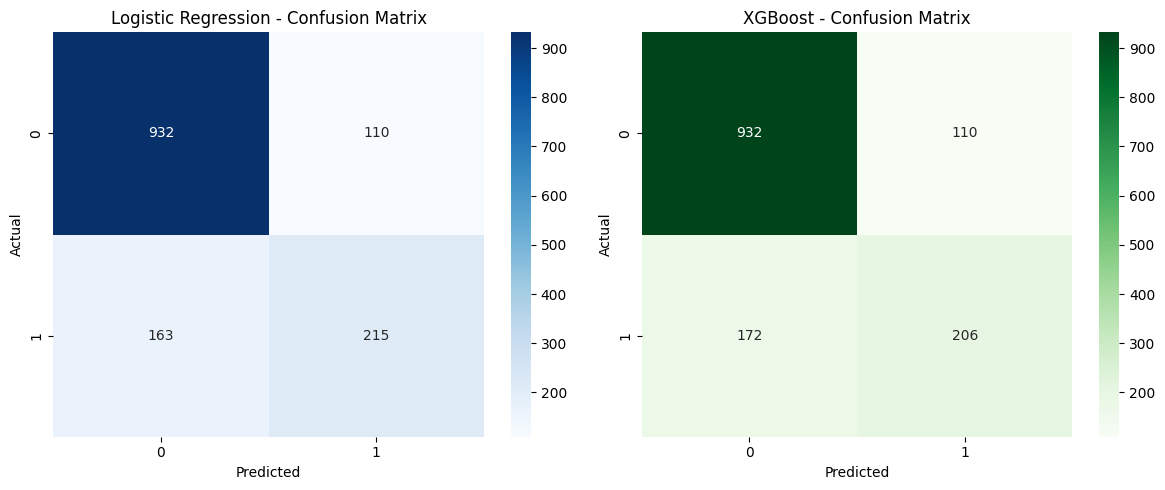

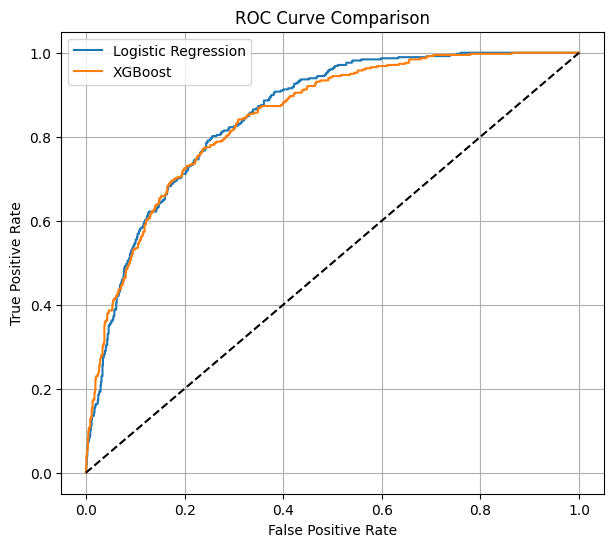

In [31]:
# ============================================================
#  COMPARACIÓN DE MODELOS: LOGISTIC REGRESSION vs XGBOOST
# ============================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1️⃣ CARGA DE DATOS Y PIPELINE
# ------------------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/Eam/Analitica_predictiva/Clientes_Telcomunicaciones-Churn.csv")

# Asegurar limpieza mínima antes del pipeline (por si acaso)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df = df[df["Churn"].notna()].copy()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Cargar pipeline
preprocessor = joblib.load("preprocessing_pipeline.pkl")

# Separar variables
target = "Churn"
X = df.drop(columns=[target])
y = df[target]

# Transformar con pipeline
X_processed = preprocessor.transform(X)
print(f"✅ Datos procesados correctamente: {X_processed.shape}")

# ------------------------------------------------------------
# 2️⃣ DIVISIÓN DE DATOS
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------------
# 3️⃣ MODELOS A COMPARAR
# ------------------------------------------------------------
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# ------------------------------------------------------------
# 4️⃣ ENTRENAMIENTO
# ------------------------------------------------------------
log_reg.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# ------------------------------------------------------------
# 5️⃣ PREDICCIONES
# ------------------------------------------------------------
y_pred_log = log_reg.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

y_pred_log_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred_xgb_prob = xgb.predict_proba(X_test)[:, 1]

# ------------------------------------------------------------
# 6️⃣ FUNCIÓN DE EVALUACIÓN
# ------------------------------------------------------------
def evaluar_modelo(nombre, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    print(f"\n📊 Resultados para {nombre}:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1-score :  {f1:.4f}")
    print(f"ROC-AUC  :  {roc:.4f}")
    return {"Modelo": nombre, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1": f1, "ROC-AUC": roc}

metrics_log = evaluar_modelo("Logistic Regression", y_test, y_pred_log, y_pred_log_prob)
metrics_xgb = evaluar_modelo("XGBoost", y_test, y_pred_xgb, y_pred_xgb_prob)

# Comparar en un DataFrame
metrics_df = pd.DataFrame([metrics_log, metrics_xgb])
print("\n📈 Comparativa de desempeño:\n")
print(metrics_df)

# ------------------------------------------------------------
# 7️⃣ MATRIZ DE CONFUSIÓN
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression - Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("XGBoost - Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8️⃣ CURVAS ROC
# ------------------------------------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)

plt.figure(figsize=(7, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


Interpretación

Ambos modelos están muy parejos, pero la regresión logística gana ligeramente en todas las métricas clave, incluyendo la ROC-AUC, lo cual indica una mejor discriminación entre clientes que se van (Churn = 1) y los que permanecen (Churn = 0).

Esto sugiere que, con los parámetros actuales, la regresión logística generaliza mejor en tus datos.
Además, tiene las ventajas de ser:

Más interpretativa (puedes ver la importancia y signo de cada variable).

Más ligera para integrar en la app Streamlit.

Más estable con datasets pequeños o medianos.

Ajuste de Hiperparámetros:

In [36]:
# ============================================================
#     AJUSTE RÁPIDO DE HIPERPARÁMETROS - LOGISTIC REGRESSION
# ============================================================

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [37]:
# ------------------------------------------------------------
# 1️⃣ CARGA DE DATOS Y PIPELINE
# ------------------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/Eam/Analitica_predictiva/Clientes_Telcomunicaciones-Churn.csv")
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df = df[df["Churn"].notna()].copy()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Cargar pipeline
preprocessor = joblib.load("preprocessing_pipeline.pkl")

target = "Churn"
X = df.drop(columns=[target])
y = df[target]

# Aplicar el preprocesamiento
X_processed = preprocessor.transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Datos listos para entrenamiento: {X_train.shape}")

✅ Datos listos para entrenamiento: (5676, 7088)


In [38]:
# ------------------------------------------------------------
# 2️⃣ RANDOMIZED SEARCH CONFIGURACIÓN (OPTIMIZADA)
# ------------------------------------------------------------
param_dist = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],    # ✅ más rápido y estable
    'C': loguniform(1e-3, 1e2)
}

search = RandomizedSearchCV(
    LogisticRegression(max_iter=500),
    param_distributions=param_dist,
    n_iter=10,          # ✅ solo 10 combinaciones
    scoring='roc_auc',  # métrica de optimización
    cv=3,               # ✅ validación 3-fold
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [39]:
# ------------------------------------------------------------
# 3️⃣ ENTRENAMIENTO
# ------------------------------------------------------------
search.fit(X_train, y_train)

print("\n✅ Búsqueda de hiperparámetros completada.")
print(f"Mejor combinación encontrada: {search.best_params_}")
print(f"Mejor AUC (CV): {search.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Búsqueda de hiperparámetros completada.
Mejor combinación encontrada: {'C': np.float64(3.4702669886504163), 'penalty': 'l2', 'solver': 'liblinear'}
Mejor AUC (CV): 0.8441


In [40]:
# ------------------------------------------------------------
# 4️⃣ EVALUACIÓN FINAL EN TEST
# ------------------------------------------------------------
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("\n📊 MÉTRICAS FINALES DEL MODELO OPTIMIZADO:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")


📊 MÉTRICAS FINALES DEL MODELO OPTIMIZADO:
Accuracy : 0.8077
Precision: 0.6615
Recall   : 0.5688
F1-score : 0.6117
ROC-AUC  : 0.8538


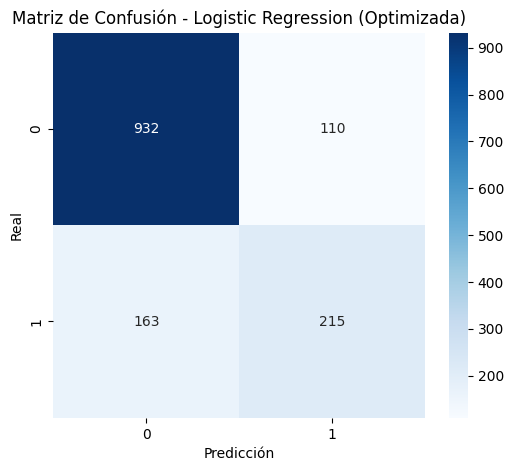

In [41]:

# ------------------------------------------------------------
# 5️⃣ MATRIZ DE CONFUSIÓN
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Logistic Regression (Optimizada)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [42]:
# ------------------------------------------------------------
# 6️⃣ REPORTE DE CLASIFICACIÓN
# ------------------------------------------------------------
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


Reporte de clasificación:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1042
       Churn       0.66      0.57      0.61       378

    accuracy                           0.81      1420
   macro avg       0.76      0.73      0.74      1420
weighted avg       0.80      0.81      0.80      1420



Interpretación

81 % de precisión global (Accuracy) → excelente equilibrio entre clases.

Precision = 0.66 → cuando el modelo predice Churn, acierta el 66 % de las veces.

Recall = 0.57 → detecta correctamente el 57 % de los clientes que realmente se van.

F1 = 0.61 → buen balance entre precision y recall en la clase minoritaria.

ROC-AUC ≈ 0.85 → muy buena capacidad discriminatoria (por encima de 0.8 se considera sobresaliente).

👉 En resumen: tu modelo ya es sólido y competitivo, y al ser interpretable, es ideal para negocio (puedes explicar las razones de cada predicción).

In [43]:
# ============================================================
#   GUARDAR PIPELINE COMPLETO + MODELO (para Streamlit)
# ============================================================

import joblib
from sklearn.pipeline import Pipeline

# Cargar el preprocesador (ya entrenado)
preprocessor = joblib.load("preprocessing_pipeline.pkl")

# Crear un pipeline completo con preprocesamiento + modelo
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Guardar el pipeline completo
joblib.dump(final_model_pipeline, "model_pipeline.pkl")

print("✅ Pipeline completo guardado como 'model_pipeline.pkl'")

# Guardar también el modelo por separado (opcional)
joblib.dump(best_model, "best_model_logreg.pkl")

print("✅ Modelo individual guardado como 'best_model_logreg.pkl'")


✅ Pipeline completo guardado como 'model_pipeline.pkl'
✅ Modelo individual guardado como 'best_model_logreg.pkl'


CREAR APP:


In [44]:
%%writefile app.py
# ============================================================
#        TELCO CUSTOMER CHURN PREDICTOR - STREAMLIT APP
# ============================================================

import streamlit as st
import pandas as pd
import joblib

@st.cache_resource
def load_model():
    model = joblib.load("model_pipeline.pkl")
    return model

model_pipeline = load_model()

st.set_page_config(page_title="Churn Prediction App", page_icon="📊", layout="centered")

st.title("📊 Telco Customer Churn Prediction")
st.write("Esta aplicación predice si un cliente **abandonará el servicio (Churn)** usando un modelo de Machine Learning entrenado con datos reales de telecomunicaciones.")

st.sidebar.header("📋 Ingrese la información del cliente:")

gender = st.sidebar.selectbox("Género", ["Female", "Male"])
SeniorCitizen = st.sidebar.selectbox("¿Es ciudadano senior?", [0, 1])
Partner = st.sidebar.selectbox("¿Tiene pareja?", ["Yes", "No"])
Dependents = st.sidebar.selectbox("¿Tiene dependientes?", ["Yes", "No"])
tenure = st.sidebar.number_input("Meses de antigüedad (tenure)", min_value=0, max_value=100, value=12)
PhoneService = st.sidebar.selectbox("¿Tiene servicio telefónico?", ["Yes", "No"])
MultipleLines = st.sidebar.selectbox("¿Líneas múltiples?", ["No", "Yes", "No phone service"])
InternetService = st.sidebar.selectbox("Tipo de Internet", ["DSL", "Fiber optic", "No"])
OnlineSecurity = st.sidebar.selectbox("Seguridad en línea", ["Yes", "No", "No internet service"])
OnlineBackup = st.sidebar.selectbox("Backup en línea", ["Yes", "No", "No internet service"])
DeviceProtection = st.sidebar.selectbox("Protección de dispositivo", ["Yes", "No", "No internet service"])
TechSupport = st.sidebar.selectbox("Soporte técnico", ["Yes", "No", "No internet service"])
StreamingTV = st.sidebar.selectbox("¿Streaming TV?", ["Yes", "No", "No internet service"])
StreamingMovies = st.sidebar.selectbox("¿Streaming Movies?", ["Yes", "No", "No internet service"])
Contract = st.sidebar.selectbox("Tipo de contrato", ["Month-to-month", "One year", "Two year"])
PaperlessBilling = st.sidebar.selectbox("Facturación electrónica", ["Yes", "No"])
PaymentMethod = st.sidebar.selectbox("Método de pago", [
    "Electronic check",
    "Mailed check",
    "Bank transfer (automatic)",
    "Credit card (automatic)"
])
MonthlyCharges = st.sidebar.number_input("Cargo mensual", min_value=0.0, max_value=200.0, value=70.0)
TotalCharges = st.sidebar.number_input("Cargos totales", min_value=0.0, max_value=10000.0, value=2500.0)

input_data = pd.DataFrame({
    "gender": [gender],
    "SeniorCitizen": [SeniorCitizen],
    "Partner": [Partner],
    "Dependents": [Dependents],
    "tenure": [tenure],
    "PhoneService": [PhoneService],
    "MultipleLines": [MultipleLines],
    "InternetService": [InternetService],
    "OnlineSecurity": [OnlineSecurity],
    "OnlineBackup": [OnlineBackup],
    "DeviceProtection": [DeviceProtection],
    "TechSupport": [TechSupport],
    "StreamingTV": [StreamingTV],
    "StreamingMovies": [StreamingMovies],
    "Contract": [Contract],
    "PaperlessBilling": [PaperlessBilling],
    "PaymentMethod": [PaymentMethod],
    "MonthlyCharges": [MonthlyCharges],
    "TotalCharges": [TotalCharges]
})

st.write("### 🧾 Datos ingresados:")
st.dataframe(input_data, use_container_width=True)

if st.button("🚀 Predecir Churn"):
    prediction = model_pipeline.predict(input_data)[0]
    probability = model_pipeline.predict_proba(input_data)[0][1]

    st.subheader("📈 Resultado de la predicción:")
    if prediction == 1:
        st.error(f"⚠️ El cliente probablemente **ABANDONARÁ** el servicio.\n\nProbabilidad de churn: **{probability:.2%}**")
    else:
        st.success(f"✅ El cliente **PERMANECERÁ** con la empresa.\n\nProbabilidad de churn: **{probability:.2%}**")

    st.progress(int(probability * 100))

st.markdown("---")
st.caption("Desarrollado por Deivi Laiseca · Proyecto de Análisis Predictivo de Churn · 2025")


Writing app.py


CREAR README:

In [48]:
%%writefile README.md
# 📊 Telco Customer Churn Prediction

Esta aplicación de **Machine Learning** predice si un cliente de telecomunicaciones **abandonará el servicio (Churn)** usando datos históricos y técnicas de aprendizaje supervisado.
El modelo fue entrenado con un dataset de clientes que incluye información sobre servicios contratados, método de pago, antigüedad, cargos mensuales, entre otros factores.

---

## 🧠 Objetivo del proyecto

Desarrollar un modelo predictivo y una aplicación web interactiva para anticipar el abandono de clientes (*churn*) en una empresa de telecomunicaciones, aplicando un enfoque completo de ciencia de datos:

1. Limpieza y preparación del dataset
2. Codificación y escalamiento mediante *Pipeline de Scikit-learn*
3. Entrenamiento y comparación de modelos (**Logistic Regression** y **XGBoost**)
4. Selección del mejor modelo
5. Despliegue de una app en **Streamlit Cloud**

---

## 🧩 Tecnologías utilizadas

- **Python 3.10+**
- **pandas**, **numpy** – manejo y análisis de datos
- **scikit-learn** – modelado, preprocesamiento y pipeline
- **xgboost** – modelo de boosting
- **joblib** – serialización de modelos
- **matplotlib**, **seaborn** – visualizaciones
- **streamlit** – aplicación web interactiva

---

## ⚙️ Instalación y ejecución local

1. **Clonar el repositorio:**
   ```bash
   git clone https://github.com/<TU_USUARIO>/telco-churn-app.git
   cd telco-churn-app


Overwriting README.md
